# Imports

In [84]:
%load_ext autoreload
%autoreload 2

In [2]:
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from matplotlib import cm

from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable

from skimage.feature import peak_local_max

from pynistview_utils import *
from selelems import *
# import pynistview_utils as pyn
# import selelems as sel

import cv2

# plt.style.use('dark_background')

# Set up directories and files

In [231]:
# Configure input files

indir = "/Users/rmoraski/Documents/iCloud/School/Electrons/NISTView-ish/"
sempa_file_suffix = 'sempa'

#name = "191001_Fe_whisker/Fe_whisker"

# name = "FeGd_Nov_Dec/171117_FeGd"
# run pairs: (2, 3)
name = "FeGd_Nov_Dec/FeGd100"
# run pairs: (6, 7)  (11, 10)  
#name = "FeGd_Nov_Dec/FeGd200"
# run pairs: (3, 2)  (5, 6)  
#name = 'alice/171117_FeGd'

runs = (6, 7)

# Specify the number of features - 1 in the image. This is used to segment and create masks.
segments = 2

# Specify gaussian denoising sigma
sigma = 2

# Specify non-local denoising strength h. Larger h -> more denoising.
h = 20

# Specify a scale for drawing the vector arrows. Smaller number -> longer arrow.
arrow_scale = 0.2

# Specify a color for the vector arrows.
# arrow_color = 'black'
arrow_color = 'white'

# Import files

In [232]:
image_dict = import_files(name, runs, indir)

intensity_1, intensity_1_blurred, intensity_1_flat = image_dict['i1']
intensity_2, intensity_2_blurred, intensity_2_flat = image_dict['i2']

m_1, axis_1, m_1_ydim, m_1_xdim, m_1_min, m_1_max = image_dict['m1']
m_2, axis_2, m_2_ydim, m_2_xdim, m_2_min, m_2_max = image_dict['m2']
m_3, axis_3, m_3_ydim, m_3_xdim, m_3_min, m_3_max = image_dict['m3']
m_4, axis_4, m_4_ydim, m_4_xdim, m_4_min, m_4_max = image_dict['m4']

scale = image_dict['scale']

# Align scans

Get the 2 ix images aligned as best possible

In [237]:
results_r, results_h, h, imMatches, imKeypoints = align_and_scale(intensity_1, intensity_2, m_1, m_2, m_3, m_4)
intensity_1_r, intensity_2_r, m_1_r, m_2_r, m_3_r, m_4_r = results_r
intensity_1_h, m_1_h, m_2_h = results_h

intensity_2_scaled_to_1 = rescale_to(intensity_2_r, intensity_1_r)
m_4_scaled_to_1 = rescale_to(m_4_r, m_1_r)
difference_im = intensity_2_scaled_to_1 - intensity_1_r
difference_mx = m_4_scaled_to_1 - m_1_r

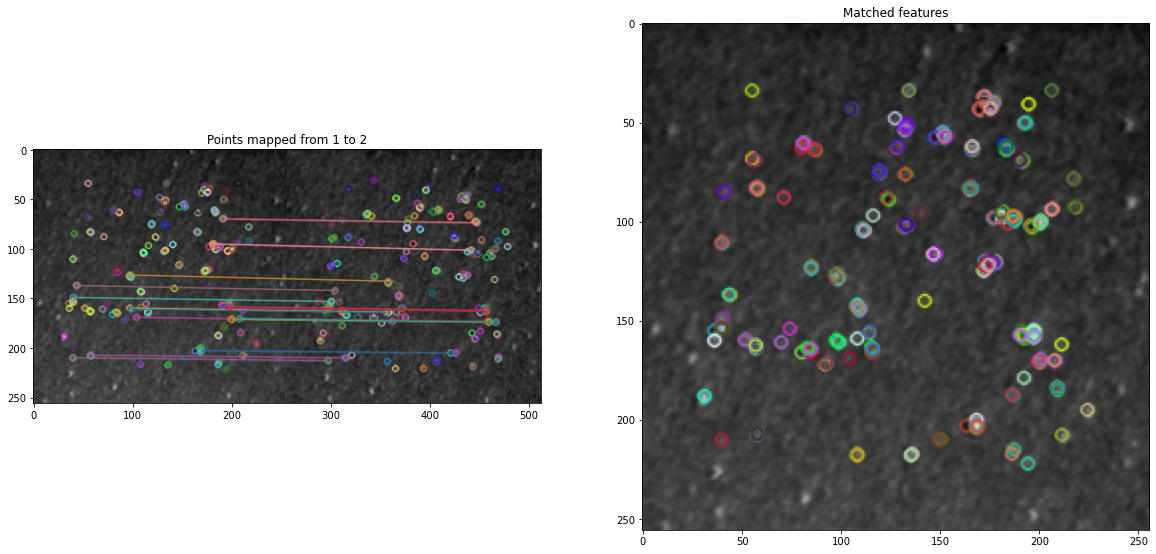

In [238]:
fig = plt.figure(figsize=(20, 10));
fig.add_subplot(121);
plt.imshow(imMatches);
plt.title('Points mapped from 1 to 2');

fig.add_subplot(122);
plt.imshow(imKeypoints);
plt.title('Matched features');

Cropped to 244 x 237


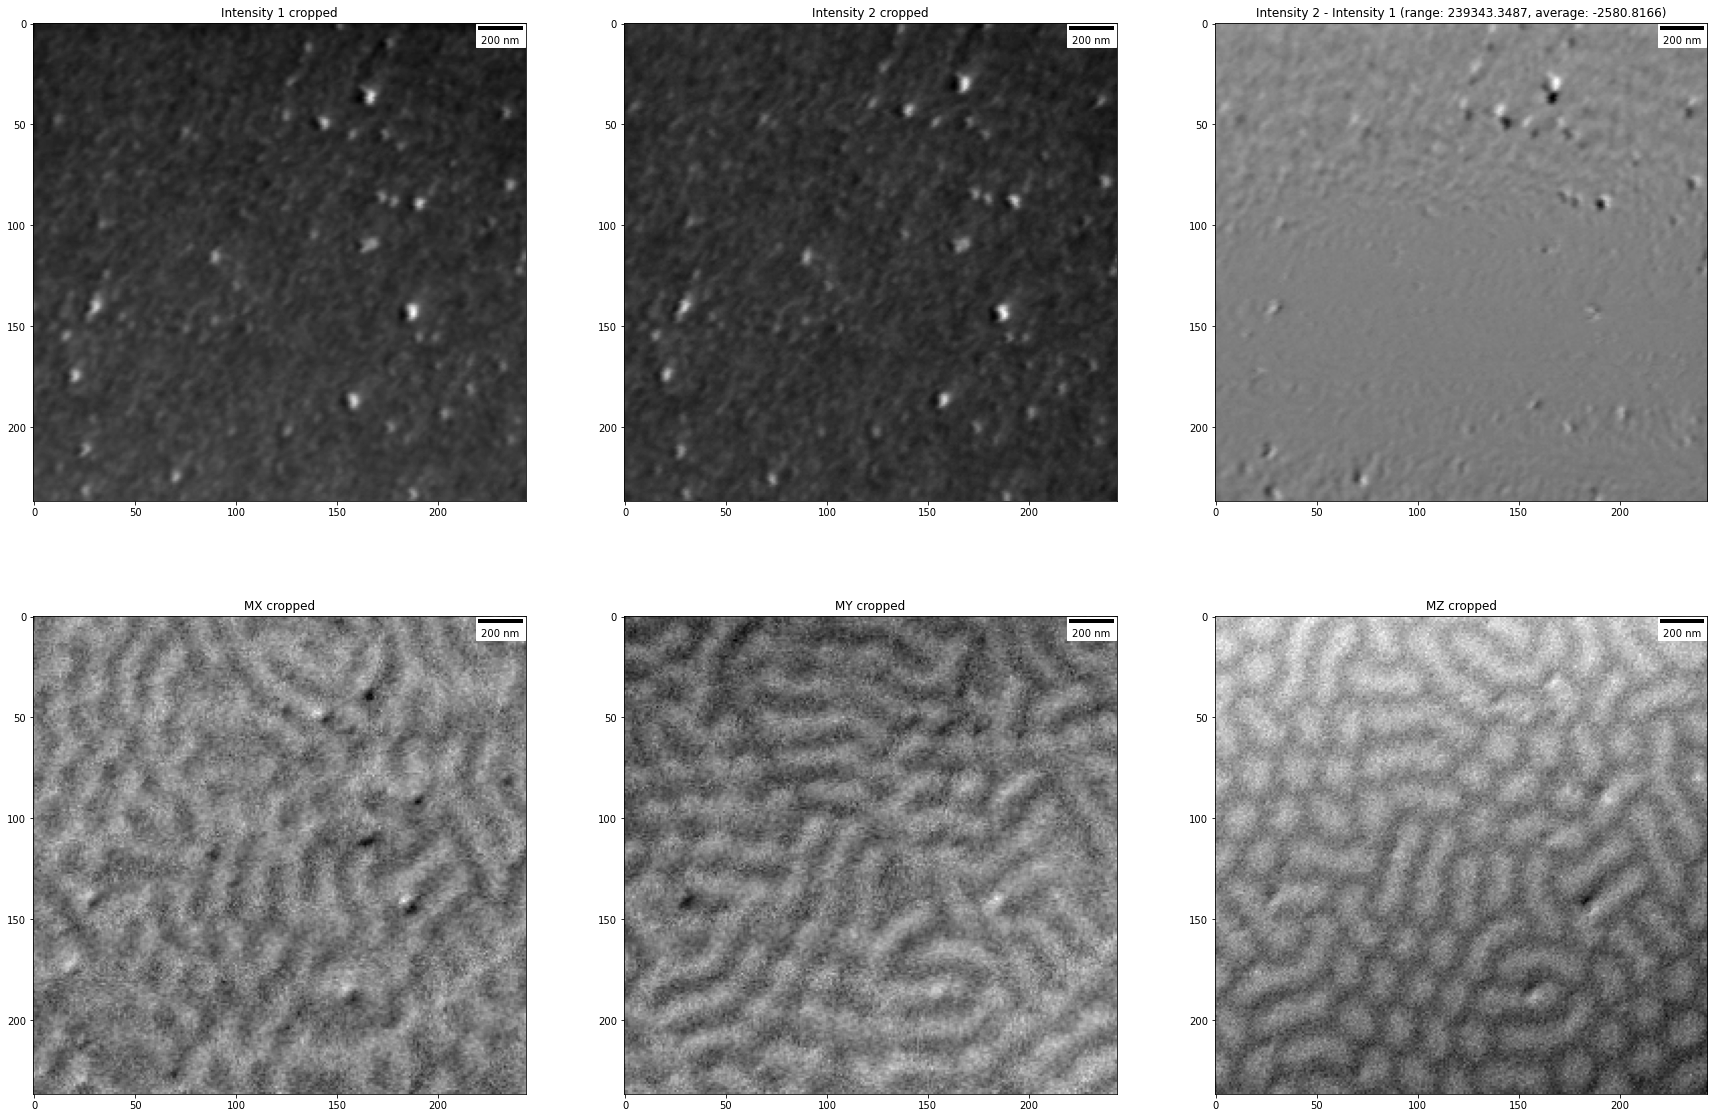

In [267]:
fig = plt.figure(figsize=(30, 20));

ax1 = fig.add_subplot(2, 3, 1);
ax1.imshow(intensity_1_r, cmap='gray');
ax1.set_title('Intensity 1 cropped')

ax2 = fig.add_subplot(2, 3, 2);
ax2.imshow(intensity_2_r, cmap='gray');
ax2.set_title('Intensity 2 cropped')

ax3 = fig.add_subplot(2, 3, 3);
ax3.imshow(difference_im, cmap='gray');
ax3.set_title('Intensity 2 - Intensity 1 (range: {:.4f}, average: {:.4f})'.format(np.ptp(difference_im), np.average(difference_im)));


ax4 = fig.add_subplot(2, 3, 4);
ax4.imshow(m_1_r, cmap='gray');
ax4.set_title('M{} cropped'.format(axis_1));

ax5 = fig.add_subplot(2, 3, 5);
ax5.imshow(m_2_r, cmap='gray');
ax5.set_title('M{} cropped'.format(axis_2));

ax6 = fig.add_subplot(2, 3, 6);
ax6.imshow(m_3_r, cmap='gray');
ax6.set_title('M{} cropped'.format(axis_3));

for ax in fig.get_axes():
    ax.add_artist(ScaleBar(scale));
    
print('Cropped to {} x {}'.format(intensity_1_r.shape[1], intensity_1_r.shape[0]))

# Find offsets

The imaging components do not use the same zero point. Since the magnetization vector should have the same magnitude over the entire sample, minimize the min to max spread across the combined images.

In [280]:
# Find averages for each image and shift the values
m_1_average, m_2_average, m_3_average = np.average(m_1_r), np.average(m_2_r), np.average(m_3_r)
m_1_shifted, m_2_shifted, m_3_shifted = m_1 - m_1_average, m_2 - m_2_average, m_3 - m_3_average

# Optimize the amount of shift necessary by minimizing least squares fitting
(m_1_offset, m_2_offset, m_3_offset), status, message = find_offsets(m_1_shifted, m_2_shifted, m_3_shifted)
m_1_offset_opt, m_2_offset_opt, m_3_offset_opt = m_1_average + m_1_offset, m_2_average + m_2_offset, m_3_average + m_3_offset
m_1_adjusted, m_2_adjusted, m_3_adjusted = m_1_r - m_1_offset_opt, m_2_r - m_2_offset_opt, m_3_r - m_3_offset_opt

m_1_adjusted = m_1_adjusted - fit_image(m_1_adjusted)[0]
m_2_adjusted = m_2_adjusted - fit_image(m_2_adjusted)[0]
m_3_adjusted = m_3_adjusted - fit_image(m_3_adjusted)[0]

# (m_1_offset, m_2_offset, m_3_offset), status, message = find_offsets(m_1_r, m_2_r, m_3_r)
# m_1_adjusted, m_2_adjusted, m_3_adjusted = m_1_r - m_1_offset, m_2_r - m_2_offset, m_3_r - m_3_offset

print('M{} average: {:.4f}, M{} average: {:.4f}, M{} average: {:.4f}'.format(
    axis_1, m_1_average, axis_2, m_2_average, axis_3, m_3_average))
print('M{} offset: {:.4f}, M{} offset: {:.4f}, M{} offset: {:.4f}'.format(
    axis_1, m_1_offset, axis_2, m_2_offset, axis_3, m_3_offset))

print('M{} original range: {:.4f} to {:.4f}; offset range: {:.3f}, {:.4f} to {:.4f}'.format(
    axis_1, m_1_min, m_1_max, np.ptp(m_1_adjusted), m_1_adjusted.min(), m_1_adjusted.max()))
print('M{} original range: {:.4f} to {:.4f}; offset range: {:.3f}, {:.4f} to {:.4f}'.format(
    axis_2, m_2_min, m_2_max, np.ptp(m_2_adjusted), m_2_adjusted.min(), m_2_adjusted.max()))
print('M{} original range: {:.4f} to {:.4f}; offset range: {:.3f}, {:.4f} to {:.4f}'.format(
    axis_3, m_3_min, m_3_max, np.ptp(m_3_adjusted), m_3_adjusted.min(), m_3_adjusted.max()))

MX average: 1.2554, MY average: -0.5172, MZ average: 0.0758
MX offset: -0.0041, MY offset: -0.0049, MZ offset: -0.0018
MX original range: 1.1648 to 1.3357; offset range: 0.161, -0.0786 to 0.0821
MY original range: -0.5950 to -0.4314; offset range: 0.142, -0.0644 to 0.0778
MZ original range: -0.0573 to 0.2185; offset range: 0.209, -0.1114 to 0.0972


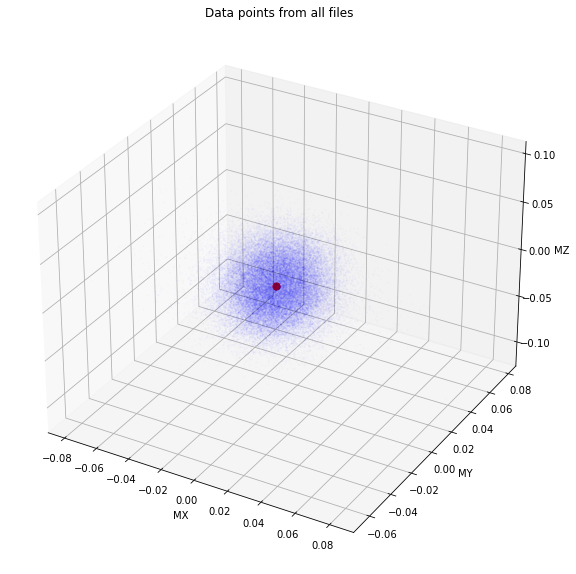

In [281]:
fig = plt.figure(figsize=(10, 10));
ax1 = fig.add_subplot(111, projection='3d');

ax1.scatter3D(m_1_adjusted.flatten(), m_2_adjusted.flatten(), m_3_adjusted.flatten(), s=1, c='blue', alpha=0.01);
ax1.scatter3D(0, 0, 0, s=50, c='red');
ax1.set_xlabel('M{}'.format(axis_1));
ax1.set_ylabel('M{}'.format(axis_2));
ax1.set_zlabel('M{}'.format(axis_3));
plt.title('Data points from all files');

In [282]:
magnitudes = get_magnitudes(m_1_adjusted, m_2_adjusted, m_3_adjusted)
magnitudes /= magnitudes.max()
phis, thetas = get_phases(m_1_adjusted, m_2_adjusted, m_3_adjusted)

# Apply a light gaussian filter to clean up the images
magnitudes_flattened = rescale_to(gaussian_filter(magnitudes, 3), magnitudes)
phis_flattened = rescale_to(gaussian_filter(phis, 3), phis)
thetas_flattened = rescale_to(gaussian_filter(thetas, 3), thetas)

mag_low, mag_high = np.percentile(magnitudes, 5), np.percentile(magnitudes, 95)

print('Magnitudes range from {:.4f} to {:.4f} with mean {:.4f} and 90% confidence interval {:.4f}..{:.4f}'.format(
    magnitudes.min(), magnitudes.max(), magnitudes.mean(), mag_low, mag_high))
print('\N{greek small letter phi} ranges from {:.4f} to {:.4f}'.format(phis.min(), phis.max()))
print('\N{greek small letter theta} ranges from {:.4f} to {:.4f}'.format(thetas.min(), thetas.max()))

Magnitudes range from 0.0042 to 1.0000 with mean 0.1950 and 90% confidence interval 0.0756..0.3397
φ ranges from 0.0000 to 6.2831
θ ranges from 0.0090 to 3.1378


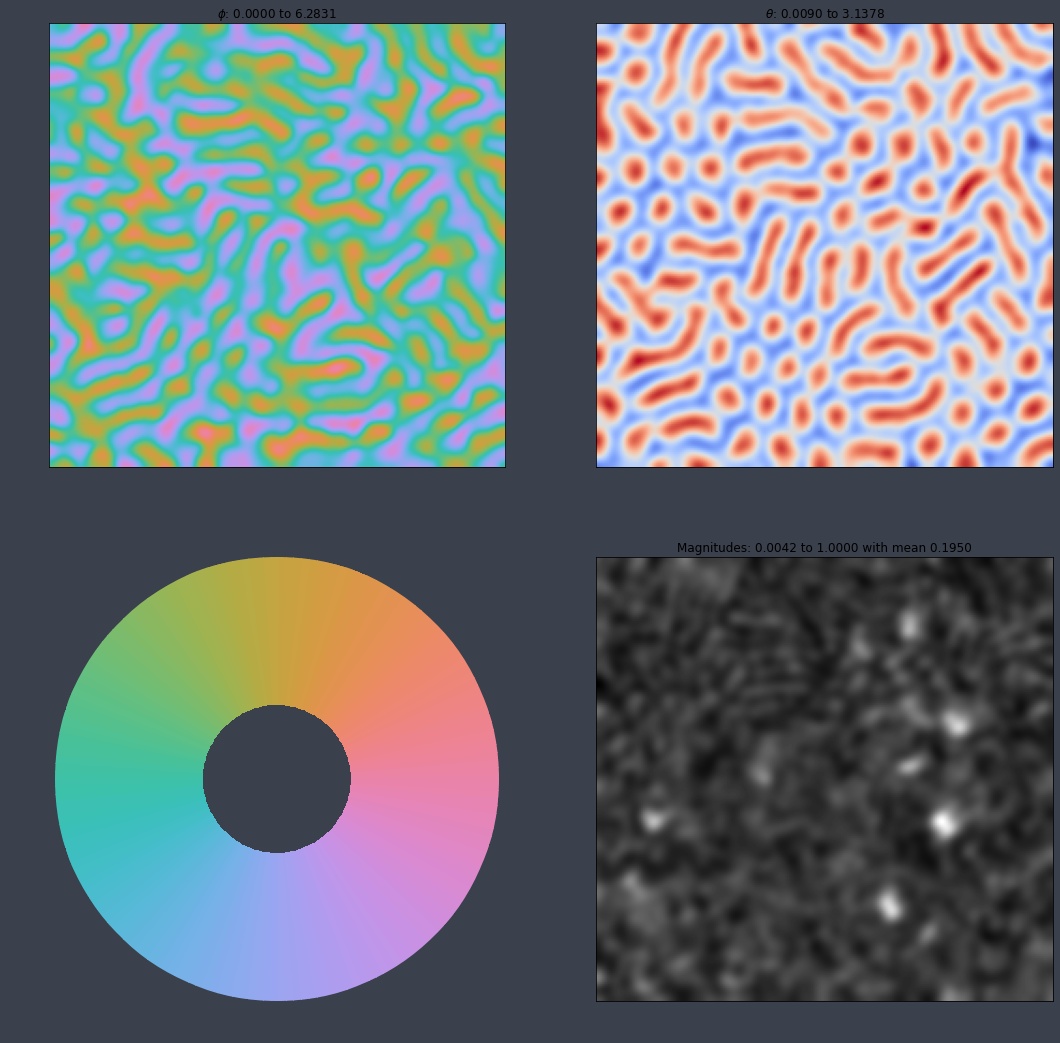

In [283]:
plt.figure(figsize=(18, 18));

ax1 = plt.subplot(2, 2, 1);
ax1.imshow(phis_flattened, cmap=create_ciecam02_cmap());
ax1.set_title(r'$\phi$: {:.4f} to {:.4f}'.format(phis_flattened.min(), phis_flattened.max()));
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

ax2 = plt.subplot(2, 2, 2);
ax2.imshow(thetas_flattened, cmap=cm.coolwarm);
ax2.set_title(r'$\theta$: {:.4f} to {:.4f}'.format(thetas_flattened.min(), thetas_flattened.max()));
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

ax3 = plt.subplot(2, 2, 3, polar=True)
show_phase_colors_circle(ax3)
ax3.set_title(r'');#, fontdict={'fontsize': 20})

ax4 = plt.subplot(2, 2, 4);
ax4.imshow(magnitudes_flattened, cmap='gray');
ax4.set_title('Magnitudes: {:.4f} to {:.4f} with mean {:.4f}'.format(magnitudes.min(), magnitudes.max(), magnitudes.mean()));
ax4.axes.get_xaxis().set_visible(False)
ax4.axes.get_yaxis().set_visible(False)


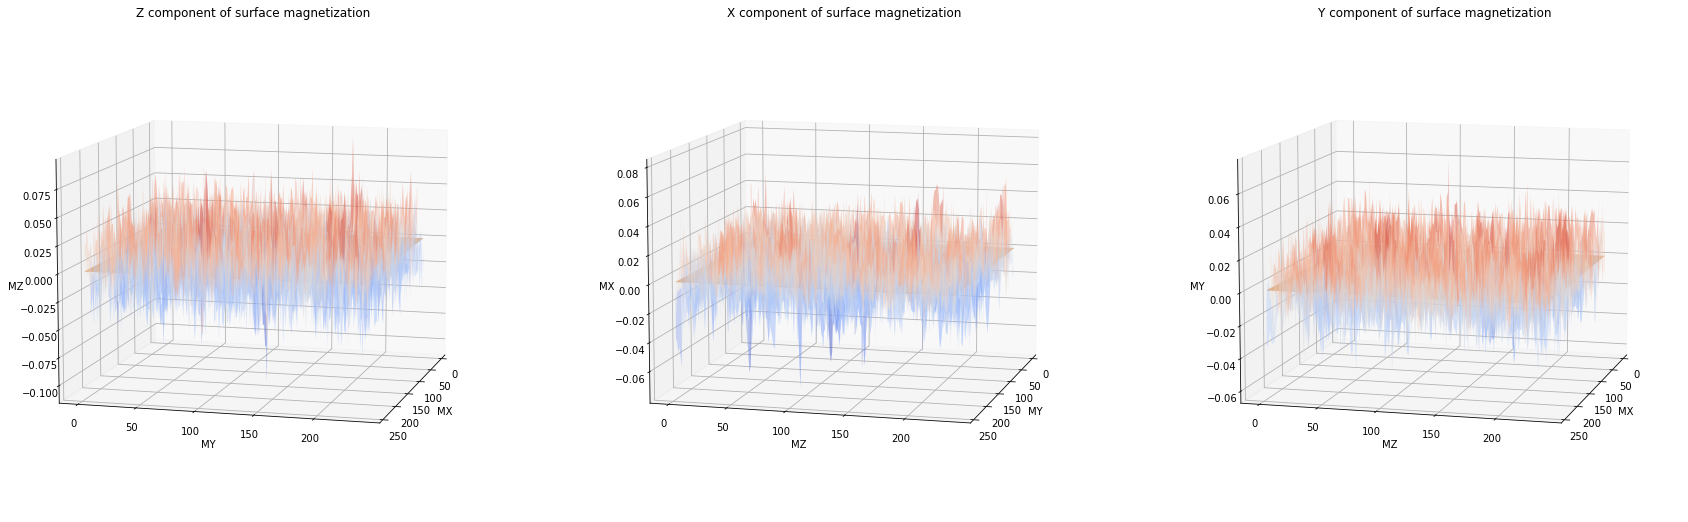

In [285]:
# %matplotlib widget

azim, elev = 15, 10;

xs, ys = np.linspace(1, magnitudes.shape[1], magnitudes.shape[1]), np.linspace(1, magnitudes.shape[0], magnitudes.shape[0])
Xs, Ys = np.meshgrid(xs, ys)

zs = m_3_adjusted # magnitudes * np.cos(thetas_flattened)

fig = plt.figure(figsize=(30, 11));
ax1 = fig.add_subplot(1, 3, 1, projection='3d');
ax1.azim = azim;
ax1.elev = elev;
# ax.contour3D(Xs, Ys, zs, 100, cmap=cm.coolwarm, alpha=0.5);
surface = ax1.plot_surface(Xs, Ys, zs, cmap=cm.coolwarm, linewidth=0, alpha=0.3);
ax1.plot_surface(Xs, Ys, np.zeros_like(Xs), alpha=0.5)
# ax.plot_wireframe(Xs, Ys, zs, cmap=cm.coolwarm);

ax1.set_xlabel('M{}'.format(axis_1));
ax1.set_ylabel('M{}'.format(axis_2));
ax1.set_zlabel('M{}'.format(axis_3));
plt.title('{} component of surface magnetization'.format(axis_3));

ax2 = fig.add_subplot(1, 3, 2, projection='3d');
ax2.azim = azim;
ax2.elev = elev;
# ax.contour3D(Xs, Ys, zs, 100, cmap=cm.coolwarm, alpha=0.5);
surface = ax2.plot_surface(Xs, Ys, m_1_adjusted, cmap=cm.coolwarm, linewidth=0, alpha=0.3);
ax2.plot_surface(Xs, Ys, np.zeros_like(Xs), alpha=0.5)
# ax.plot_wireframe(Xs, Ys, zs, cmap=cm.coolwarm);

ax2.set_xlabel('M{}'.format(axis_2));
ax2.set_ylabel('M{}'.format(axis_3));
ax2.set_zlabel('M{}'.format(axis_1));
plt.title('{} component of surface magnetization'.format(axis_1));

ax3 = fig.add_subplot(1, 3, 3, projection='3d');
ax3.azim = azim;
ax3.elev = elev;
# ax.contour3D(Xs, Ys, zs, 100, cmap=cm.coolwarm, alpha=0.5);
surface = ax3.plot_surface(Xs, Ys, m_2_adjusted, cmap=cm.coolwarm, linewidth=0, alpha=0.3);
ax3.plot_surface(Xs, Ys, np.zeros_like(Xs), alpha=0.5)
# ax.plot_wireframe(Xs, Ys, zs, cmap=cm.coolwarm);

ax3.set_xlabel('M{}'.format(axis_1));
ax3.set_ylabel('M{}'.format(axis_3));
ax3.set_zlabel('M{}'.format(axis_2));
plt.title('{} component of surface magnetization'.format(axis_2));

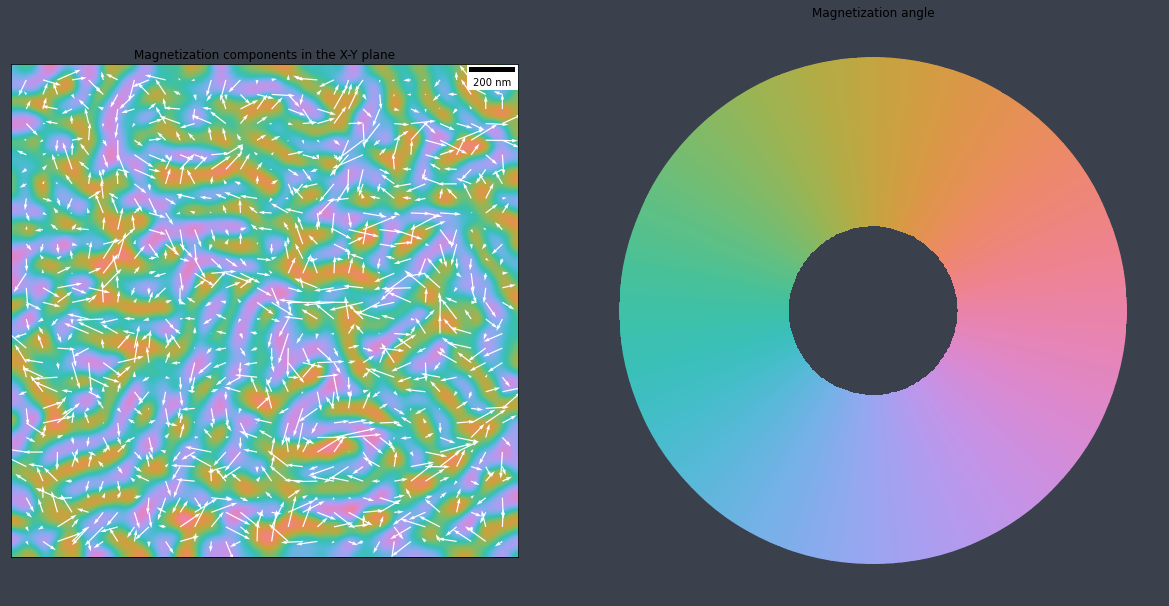

In [286]:
# %matplotlib inline

magnitudes_2d = get_magnitudes(m_1_adjusted, m_2_adjusted)
magnitudes_2d /= magnitudes_2d.max()

# phis_2d, _ = get_phases(m_1_r, m_2_r)
phis_2d, _ = get_phases(m_1_adjusted, m_2_adjusted)

img = render_phases_and_magnitudes(phis_2d, magnitudes_2d)
# print(img.min(), img.max(), phis_2d.min(), phis_2d.max())

# plt.style.use('dark_background');
fig = plt.figure(figsize=(20, 10));
ax = fig.add_subplot(121);
ax.imshow(rescale_to(gaussian_filter(phis_2d, 3), phis_2d),
           cmap=create_ciecam02_cmap());
ax.add_artist(ScaleBar(scale));
ax.set_title('Magnetization components in the {}-{} plane'.format(axis_1, axis_2));
# plt.subplot(1, 2, 2);
show_vector_plot(m_1_adjusted, m_2_adjusted, ax, scale=0.1);

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax2 = fig.add_subplot(122, polar=True);
show_phase_colors_circle(ax2); #, add_dark_background=False, text_color='black');
ax2.set_title('Magnetization angle');

In [287]:
# magnitudes = get_magnitudes(m_1_adjusted, m_2_adjusted, m_3_adjusted)

# Get dimensions. divisor is the step between samples for vector arrows.
yd, xd = magnitudes.shape
divisor = 6

# Get an even number of samples in both directions
samples_x_half, samples_y_half =  math.ceil(xd // divisor), math.ceil(yd // divisor)
samples_x, samples_y = samples_x_half * 2, samples_y_half * 2

# Build a convolution kernel with odd dimensions
kernel_tweak_x, kernel_tweak_y = samples_x_half % 2 - 1, samples_y_half % 2 - 1
kernel = np.ones((samples_y // 2 - kernel_tweak_y, samples_x // 2 - kernel_tweak_x))
kernel = np.ones((3, 3))

X = np.linspace(xd / samples_x, xd * (samples_x - 1) / samples_x, samples_x, dtype=np.uint8)
Y = np.linspace(yd / samples_y, yd * (samples_y - 1) / samples_y, samples_y, dtype=np.uint8)

# Create a pair of (x, y) coordinates
U, V = np.meshgrid(X, Y)
W = np.zeros_like(U)

Us = magnitudes * np.cos(phis_flattened) * np.sin(thetas_flattened)
Vs = magnitudes * np.sin(phis_flattened) * np.sin(thetas_flattened)
Ws = magnitudes * np.cos(thetas_flattened)

x, y, z = U.ravel(), V.ravel(), W.ravel()

# Pull the values at those coordinates.
Us_g = convolve2d(Us, kernel, mode='same')[y, x].reshape(U.shape)
Vs_g = convolve2d(Vs, kernel, mode='same')[y, x].reshape(V.shape)
Ws_g = convolve2d(Ws, kernel, mode='same')[y, x].reshape(W.shape)

# Us_g = convolve2d(m_1_adjusted, kernel, mode='same')[y, x].reshape(U.shape)
# Vs_g = convolve2d(m_2_adjusted, kernel, mode='same')[y, x].reshape(V.shape)
# Ws_g = convolve2d(m_3_adjusted, kernel, mode='same')[y, x].reshape(W.shape)

print('M{}   min/max: ({:.3f}, {:.3f}), M{}   min/max: ({:.3f}, {:.3f}), M{}   min/max: ({:.3f}, {:.3f})'.format(
    axis_1, m_1_adjusted.min(), m_1_adjusted.max(), axis_2, m_2_adjusted.min(), m_2_adjusted.max(),
    axis_3, m_3_adjusted.min(), m_3_adjusted.max()));
print('Us   min/max: ({:.3f}, {:.3f}), Vs   min/max: ({:.3f}, {:.3f}), Ws   min/max: ({:.3f}, {:.3f})'.format(
    Us.min(), Us.max(), Vs.min(), Vs.max(), Ws.min(), Ws.max()));
print('Us_g min/max: ({:.3f}, {:.3f}), Vs_g min/max: ({:.3f}, {:.3f}), Ws_g min/max: ({:.3f}, {:.3f})'.format(
    Us_g.min(), Us_g.max(), Vs_g.min(), Vs_g.max(), Ws_g.min(), Ws_g.max()));

MX   min/max: (-0.079, 0.082), MY   min/max: (-0.064, 0.078), MZ   min/max: (-0.111, 0.097)
Us   min/max: (-0.624, 0.664), Vs   min/max: (-0.607, 0.627), Ws   min/max: (-0.707, 0.751)
Us_g min/max: (-3.873, 4.135), Vs_g min/max: (-3.719, 3.697), Ws_g min/max: (-4.372, 5.290)


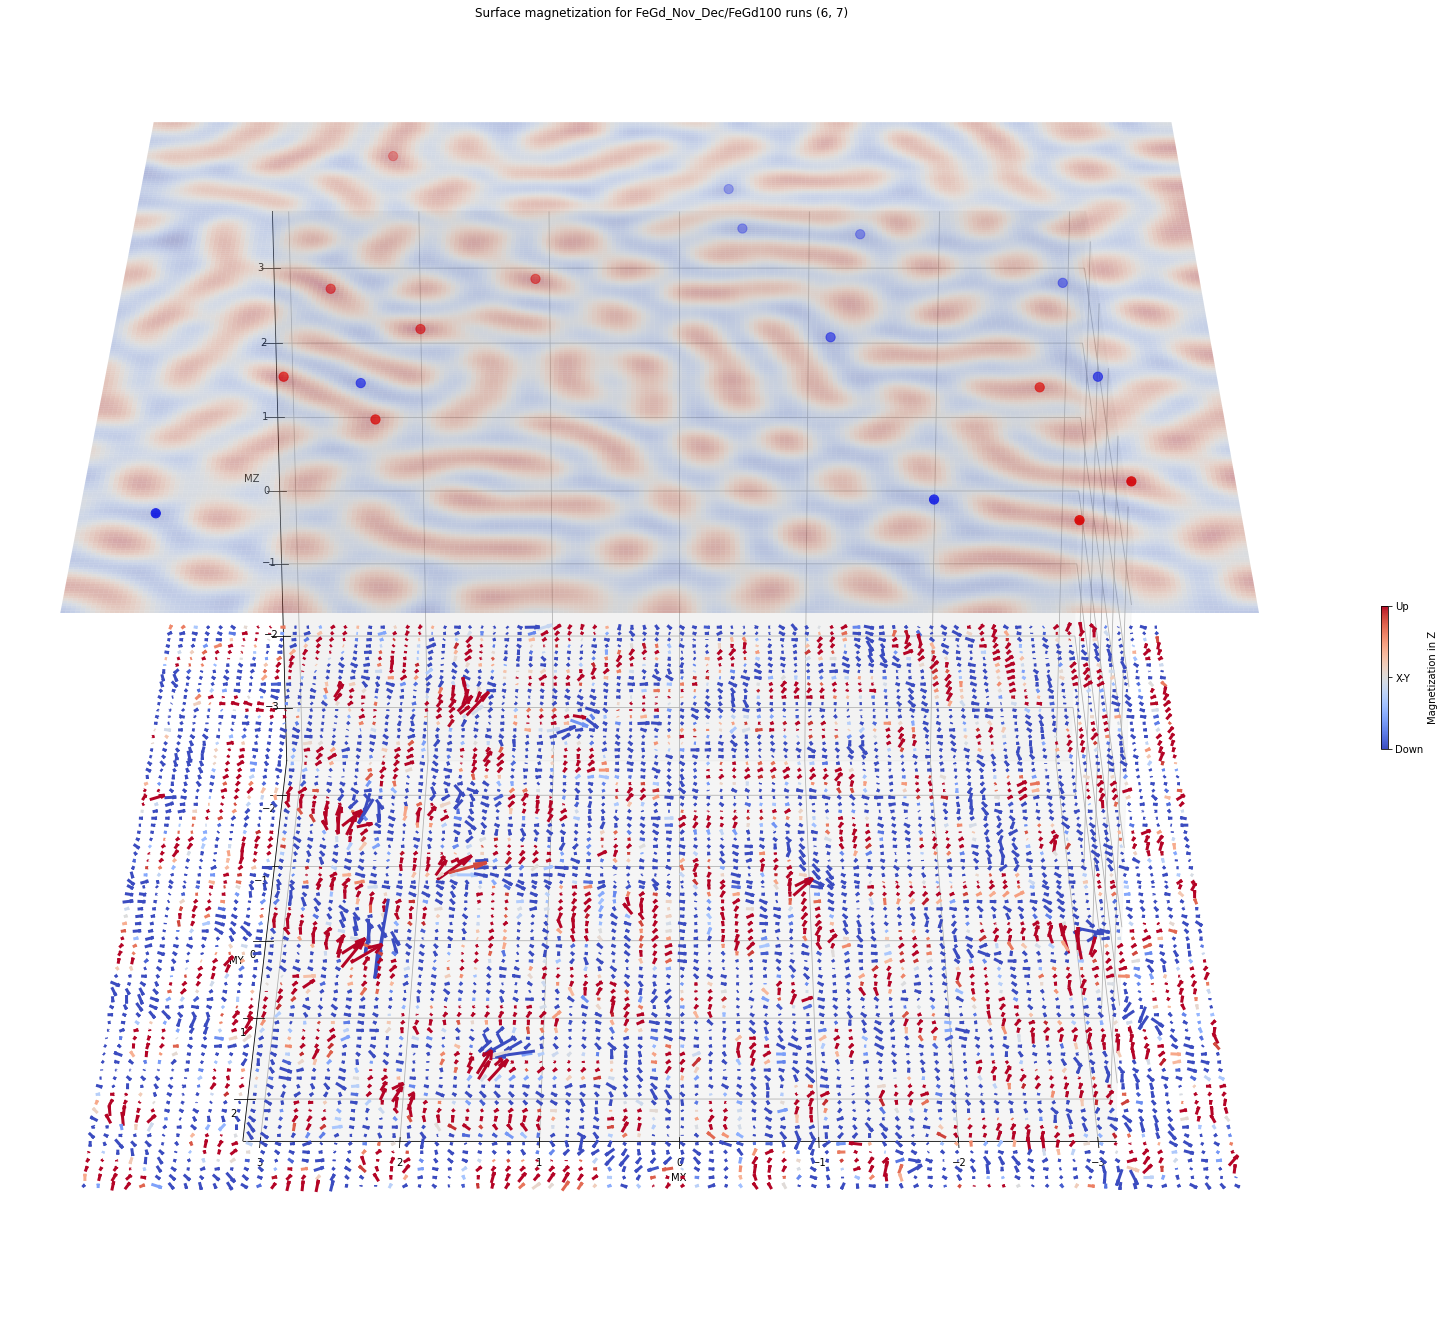

In [379]:
# %matplotlib widget

# azim and elev have units of degrees
azim, elev, dist = 90, 25, 20;
scale_factor = 0.018;
min_distance, num_peaks = 15, 9;

# Set things up for the scale of the calculated magnitudes
xlim = np.ceil(np.abs(Us_g).max())
ylim = np.ceil(np.abs(Vs_g).max())
zlim = np.ceil(np.abs(Ws_g).max())

xs, ys = rescale_to(x, Us_g), rescale_to(y, Vs_g)
lengths = np.sqrt(Us_g**2 + Vs_g**2 + Ws_g**2)

# plt.style.use('classic');
# plt.style.available

fig = plt.figure(figsize=(20, 20), constrained_layout=True);
ax = fig.add_subplot(111, projection='3d');
# fig.subplots_adjust(left=0, right=0.1, bottom=0, top=0.1);

# ax.set_box_aspect((np.ptp(Us_g), np.ptp(Vs_g), np.ptp(Ws_g) * scale_factor))
# ax.set_box_aspect((np.ptp(Us_g), np.ptp(Vs_g), 2 * zlim))

# Plot the x-y phase map at z=-3, z phases at z=3. Meshgrid for x and y, array of z=0, use
# phis and thetas as the facecolors of the surface plots
x_range, y_range = np.linspace(Us_g.min(), Us_g.max(), xd), np.linspace(Vs_g.min(), Vs_g.max(), yd)
surf_x, surf_y = np.meshgrid(x_range, y_range)
surf_z = np.zeros_like(phis_flattened)

cmap_phi = create_ciecam02_cmap()(phis_flattened / (2 * np.pi))
cmap_theta = cm.coolwarm(thetas_flattened / np.pi)
maxes = peak_local_max(thetas_flattened, min_distance, num_peaks=num_peaks)
mins = peak_local_max(-1 * (thetas_flattened - thetas_flattened.max()), min_distance, num_peaks=num_peaks)

# ax.plot_surface(surf_x, surf_y, surf_z - 3, alpha=0.5, linewidth=0,
#                 antialiased=True, facecolors=cmap, rcount=yd, ccount=xd);
ax.plot_surface(surf_x, surf_y, surf_z + 4, alpha=0.4, linewidth=0,
                antialiased=True, facecolors=cmap_theta, rcount=yd, ccount=xd);

# ax.scatter(xs, ys, z, color='black', alpha=0.3, s=25);
ax.scatter(x_range[maxes[:, 1]], y_range[maxes[:, 0]], np.ones(num_peaks) * 4, color='red', s=85)
ax.scatter(x_range[mins[:, 1]], y_range[mins[:, 0]], np.ones(num_peaks) * 4, color='blue', s=85)


# quiver = ax.quiver(xs, ys, z, Us_g.ravel(), Vs_g.ravel(), Ws_g.ravel(), arrow_length_ratio=0.1, pivot='tail', lw=2, alpha=0.8, cmap=cm.coolwarm);
# quiver = ax.quiver(U, V, W, Us_g/Us_g.max(), Vs_g/Vs_g.max(), Ws_g/Ws_g.max(), arrow_length_ratio=0.15, pivot='tail', lw=2, alpha=0.8, cmap=cm.coolwarm);

# Draw the arrows one at a time to get colors
for x1, y1, z1, u1, v1, w1, l in zip(xs, ys, z, Us_g.ravel(), Vs_g.ravel(), Ws_g.ravel(), lengths.ravel()):
    ax.quiver(x1, y1, z1 - 3, u1, v1, -w1, length=scale_factor * l, arrow_length_ratio=0.35,
              pivot='middle', lw=3, color=cm.coolwarm(-w1));

ax.set_xlabel('M{}'.format(axis_1));
ax.set_ylabel('M{}'.format(axis_2));
ax.set_zlabel('M{}'.format(axis_3));
#ax.set_axis_off();

# scaling = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
ax.auto_scale_xyz([-xlim, xlim], [-ylim, ylim], [-zlim, zlim]);
# ax.auto_scale_xyz([-1, 1], [-1, 1], [-1, 1]);
ax.autoscale_view(tight=True);

ax.set_title('Surface magnetization for {} runs {}'.format(name, runs));

grr_scale = 0.6

ax.set_xlim3d((grr_scale * -xlim, grr_scale * xlim));
ax.set_ylim3d((grr_scale * -ylim, grr_scale * ylim));
ax.set_zlim3d((grr_scale * -zlim, grr_scale * zlim));
# ax.set_xlim((-1, 1));
# ax.set_ylim((-1, 1));
# ax.set_zlim((-1, 1));

ax.azim = azim;
ax.elev = elev;
# ax.dist = dist;
# ax.autoscale(tight=True)

norm = Normalize()

norm.autoscale(Ws_g)
sm = cm.ScalarMappable(cmap=cm.coolwarm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, shrink=0.1);

cbar.set_ticks([0, 0.5, 1]);
cbar.ax.set_yticklabels(['Down', 'X-Y', 'Up']);
cbar.set_label('Magnetization in Z');

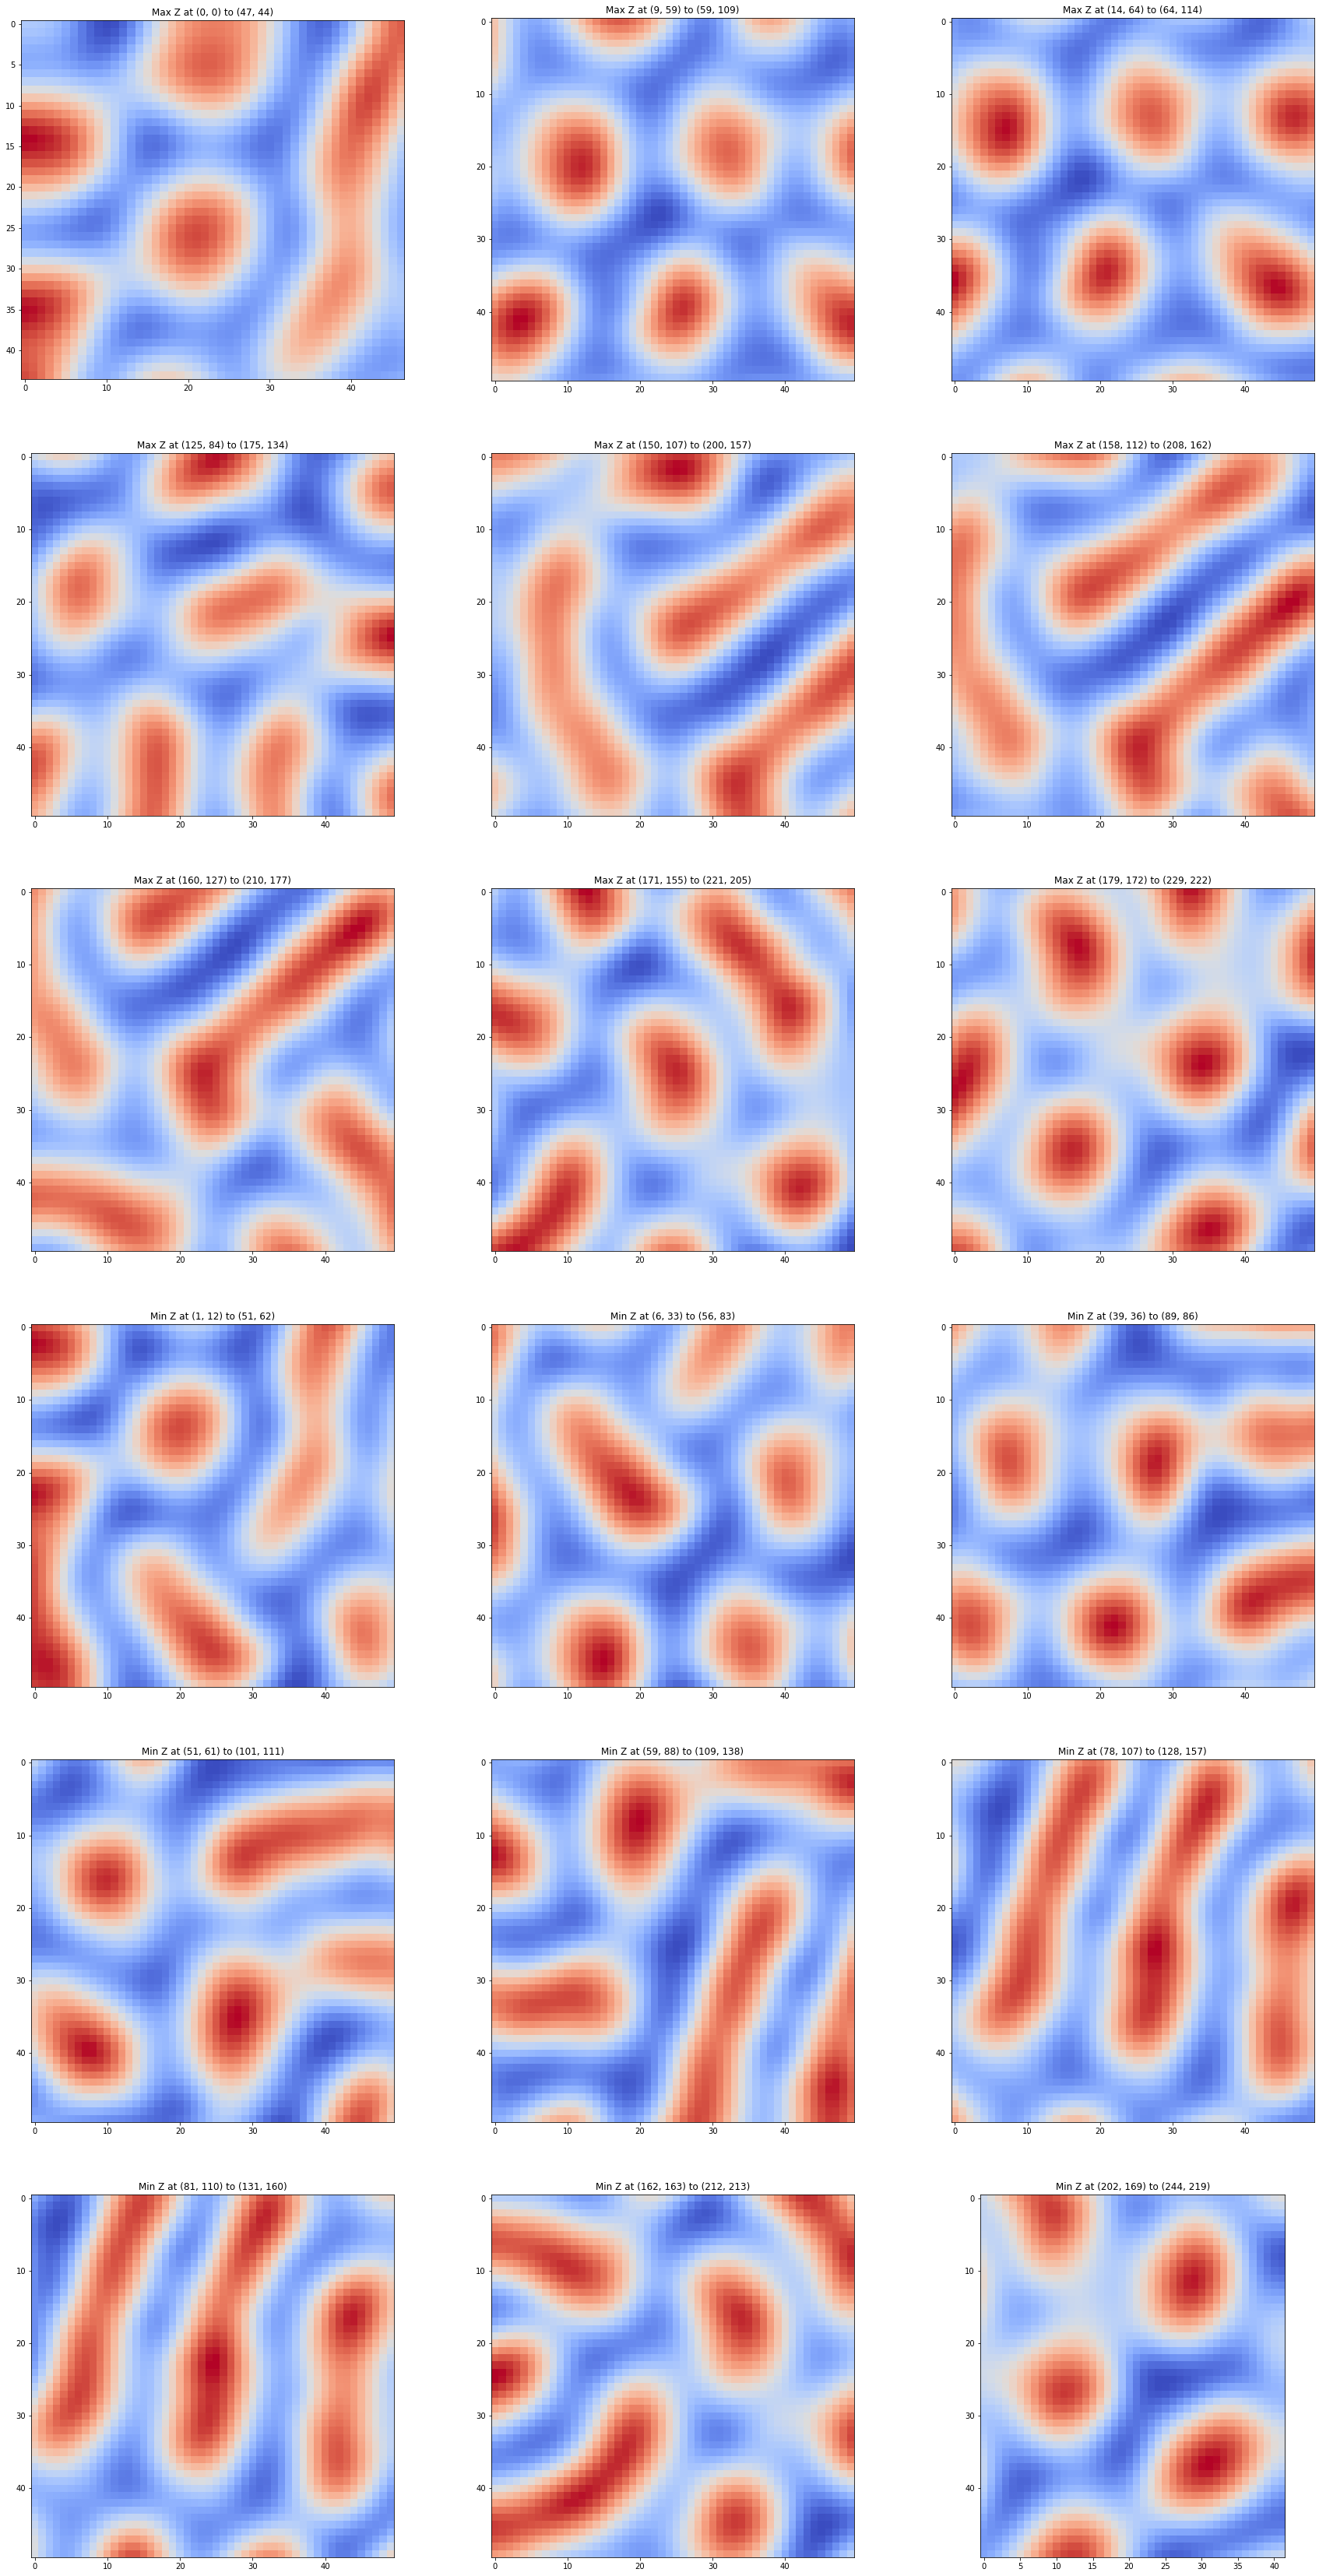

In [378]:
extent = 25

fig = plt.figure(figsize=(30, 60));
i = 1
dim_y, dim_x = thetas_flattened.shape

for max in np.sort(maxes, 0):
    xmin, xmax = np.max((0, max[1] - extent)), np.min((dim_x, max[1] + extent))
    ymin, ymax = np.max((0, max[0] - extent)), np.min((dim_y, max[0] + extent))
    plt.subplot(6, 3, i);
    plt.imshow(thetas_flattened[ymin:ymax, xmin:xmax], cmap=cm.coolwarm);
    plt.title('Max Z at ({}, {}) to ({}, {})'.format(xmin, ymin, xmax, ymax));
    
    i += 1;
    
for min in np.sort(mins, 0):
    xmin, xmax = np.max((0, min[1] - extent)), np.min((dim_x, min[1] + extent))
    ymin, ymax = np.max((0, min[0] - extent)), np.min((dim_y, min[0] + extent))
    plt.subplot(6, 3, i);
    plt.imshow(thetas_flattened[ymin:ymax, xmin:xmax], cmap=cm.coolwarm);
    plt.title('Min Z at ({}, {}) to ({}, {})'.format(xmin, ymin, xmax, ymax));
    
    i += 1;
    
# for ax in fig.get_axes():
#     ax.axes.get_xaxis().set_visible(False)
#     ax.axes.get_yaxis().set_visible(False)

# Apply offsets

In [ ]:
# Apply offsets

m_1_denoised, m_2_denoised = m_1_fitted_denoised - m_1_offset, m_2_fitted_denoised - m_2_offset

print('M{} denoised - min: {:.2f}, max: {:.2f}, average: {:.2f}, PtP: {:.2f}'.format(
    axis_1, m_1_denoised.min(), m_1_denoised.max(), np.average(m_1_denoised), np.ptp(m_1_denoised)))
print('M{} denoised - min: {:.2f}, max: {:.2f}, average: {:.2f}, PtP: {:.2f}'.format(
    axis_2, m_2_denoised.min(), m_2_denoised.max(), np.average(m_2_denoised), np.ptp(m_2_denoised)))

# Remove gradients

Imperfections in the imaging components might leave undesirable gradient artifacts in the image.

## Remove line errors

In [ ]:
m_1_delined, m_2_delined = remove_line_errors(m_1, 20), remove_line_errors(m_2, 20)
m_1_delined, m_2_delined = rescale_to(m_1_delined, m_1), rescale_to(m_2_delined, m_2)

In [ ]:
plt.figure(figsize=(20, 20));
plt.subplot(2, 2, 1);
plt.imshow(m_1, cmap='gray');
plt.title('M{}'.format(axis_1));
plt.subplot(2, 2, 2);
plt.imshow(m_2, cmap='gray');
plt.title('M{}'.format(axis_2));
plt.subplot(2, 2, 3);
plt.imshow(m_1_delined, cmap='gray');
plt.title('M{} with line errors removed'.format(axis_1));
plt.subplot(2, 2, 4);
plt.imshow(m_2_delined, cmap='gray');
plt.title('M{} with line errors removed'.format(axis_2));

## Mean shift

This is used to improve image segmentation

In [ ]:
# m_1_shift, m_2_shift = mean_shift_filter(m_1_delined), mean_shift_filter(m_2_delined)
m_1_shift, m_2_shift = mean_shift_filter(m_1), mean_shift_filter(m_2)
m_4_shift, m_3_shift = mean_shift_filter(m_4), mean_shift_filter(m_3)

In [ ]:
plt.figure(figsize=(20, 20));
plt.subplot(2, 2, 1);
plt.imshow(m_1_shift, cmap='gray');
plt.title('M{}'.format(axis_1));

plt.subplot(2, 2, 2);
plt.imshow(m_2_shift, cmap='gray');
plt.title('M{}'.format(axis_2));

plt.subplot(2, 2, 3);
plt.imshow(m_4_shift, cmap='gray');
plt.title('M{}'.format(axis_4));

plt.subplot(2, 2, 4);
plt.imshow(m_3_shift, cmap='gray');
plt.title('M{}'.format(axis_3));

## Segment

Find the features in the images

In [ ]:
m_1_thresh, m_1_seg, m_1_masks = segment_image(m_1_shift, segments=segments)
m_2_thresh, m_2_seg, m_2_masks = segment_image(m_2_shift, segments=segments)
m_3_thresh, m_3_seg, m_3_masks = segment_image(m_3_shift, segments=segments)
m_4_thresh, m_4_seg, m_4_masks = segment_image(m_4_shift, segments=segments)

In [ ]:
plt.figure(figsize=(20, 30));
plt.subplot(3, 2, 1);
plt.imshow(m_1_thresh, cmap='gray');
plt.title('Threshold');
plt.subplot(3, 2, 2);
plt.imshow(m_1_seg, cmap='gray');
plt.title('Contours');
plt.subplot(3, 2, 3);
plt.imshow(m_1_masks[0, 0], cmap='gray');
plt.title('Area 1 mask');
plt.subplot(3, 2, 4);
plt.imshow(m_1_masks[0, 1], cmap='gray');
plt.title('Area 2 mask');
plt.subplot(3, 2, 5);
plt.imshow(m_1 * m_1_masks[0, 0], vmin=m_1_min, vmax=m_1_max, cmap='gray');
plt.title('Area 1 masked');
plt.subplot(3, 2, 6);
plt.imshow(m_1 * m_1_masks[0, 1], vmin=m_1_min, vmax=m_1_max, cmap='gray');
plt.title('Area 2 masked');

plt.figure(figsize=(20, 30));
plt.subplot(3, 2, 1);
plt.imshow(m_2_thresh, cmap='gray');
plt.title('Threshold');
plt.subplot(3, 2, 2);
plt.imshow(m_2_seg, cmap='gray');
plt.title('Contours');
plt.subplot(3, 2, 3);
plt.imshow(m_2_masks[0, 0], cmap='gray');
plt.title('Area 1 mask');
plt.subplot(3, 2, 4);
plt.imshow(m_2_masks[0, 1], cmap='gray');
plt.title('Area 2 mask');
plt.subplot(3, 2, 5);
plt.imshow(m_2 * m_2_masks[0, 0], vmin=m_2_min, vmax=m_2_max, cmap='gray');
plt.title('Area 1 masked');
plt.subplot(3, 2, 6);
plt.imshow(m_2 * m_2_masks[0, 1], vmin=m_2_min, vmax=m_2_max, cmap='gray');
plt.title('Area 2 masked');

plt.figure(figsize=(20, 30));
plt.subplot(3, 2, 1);
plt.imshow(m_3_thresh, cmap='gray');
plt.title('Threshold');
plt.subplot(3, 2, 2);
plt.imshow(m_3_seg, cmap='gray');
plt.title('Contours');
plt.subplot(3, 2, 3);
plt.imshow(m_3_masks[0, 0], cmap='gray');
plt.title('Area 1 mask');
plt.subplot(3, 2, 4);
plt.imshow(m_3_masks[0, 1], cmap='gray');
plt.title('Area 2 mask');
plt.subplot(3, 2, 5);
plt.imshow(m_3 * m_3_masks[0, 0], vmin=m_3_min, vmax=m_3_max, cmap='gray');
plt.title('Area 1 masked');
plt.subplot(3, 2, 6);
plt.imshow(m_3 * m_3_masks[0, 1], vmin=m_3_min, vmax=m_3_max, cmap='gray');
plt.title('Area 2 masked');

plt.figure(figsize=(20, 30));
plt.subplot(3, 2, 1);
plt.imshow(m_4_thresh, cmap='gray');
plt.title('Threshold');
plt.subplot(3, 2, 2);
plt.imshow(m_4_seg, cmap='gray');
plt.title('Contours');
plt.subplot(3, 2, 3);
plt.imshow(m_4_masks[0, 0], cmap='gray');
plt.title('Area 1 mask');
plt.subplot(3, 2, 4);
plt.imshow(m_4_masks[0, 1], cmap='gray');
plt.title('Area 2 mask');
plt.subplot(3, 2, 5);
plt.imshow(m_4 * m_4_masks[0, 0], vmin=m_4_min, vmax=m_4_max, cmap='gray');
plt.title('Area 1 masked');
plt.subplot(3, 2, 6);
plt.imshow(m_4 * m_4_masks[0, 1], vmin=m_4_min, vmax=m_4_max, cmap='gray');
plt.title('Area 2 masked');

## Fit images

Find a polynomial fit for the images and remove the background gradient

In [ ]:
# m_1 first
m_1_light_mask, m_1_dark_mask = m_1_masks[0, 0], m_1_masks[0, 1]

m_1_light_fit_all, m_1_light_fit = fit_image(m_1, m_1_light_mask)
m_1_dark_fit_all, m_1_dark_fit = fit_image(m_1, m_1_dark_mask)

m_1_light_fitted, m_1_dark_fitted = m_1 - m_1_light_fit_all, m_1 - m_1_dark_fit_all

# and m_2
m_2_light_mask, m_2_dark_mask = m_2_masks[0, 0], m_2_masks[0, 1]

m_2_light_fit_all, m_2_light_fit = fit_image(m_2, m_2_light_mask)
m_2_dark_fit_all, m_2_dark_fit = fit_image(m_2, m_2_dark_mask)

m_2_light_fitted, m_2_dark_fitted = m_2 - m_2_light_fit_all, m_2 - m_2_dark_fit_all


# Rescale both
m_1_light_fitted, m_2_light_fitted = rescale_to(m_1_light_fitted, m_1), rescale_to(m_2_light_fitted, m_2)

In [ ]:
plt.figure(figsize=(30, 20));

plt.subplot(2, 3, 1);
plt.imshow(m_1, cmap='gray');
plt.title('M{} original'.format(axis_1));
plt.subplot(2, 3, 2);
plt.imshow(m_1_light_fit_all, cmap='gray');
plt.title('1st fit');
plt.subplot(2, 3, 3);
plt.imshow(m_1_dark_fit_all, cmap='gray');
plt.title('2nd fit');
plt.subplot(2, 3, 5);
plt.imshow(m_1_light_fitted, cmap='gray');
plt.title('Subtracted 1st fit');
plt.subplot(2, 3, 6);
plt.imshow(m_1 - m_1_dark_fit_all, cmap='gray');
plt.title('Subtracted 2nd fit');

plt.figure(figsize=(30, 20));
plt.subplot(2, 3, 1);
plt.imshow(m_2, cmap='gray');
plt.title('M{} original'.format(axis_2));
plt.subplot(2, 3, 2);
plt.imshow(m_2_light_fit_all, cmap='gray');
plt.title('1st fit');
plt.subplot(2, 3, 3);
plt.imshow(m_2_dark_fit_all, cmap='gray');
plt.title('2nd fit');
plt.subplot(2, 3, 5);
plt.imshow(m_2_light_fitted, cmap='gray');
plt.title('Subtracted 1st fit');
plt.subplot(2, 3, 6);
plt.imshow(m_2 - m_2_dark_fit_all, cmap='gray');
plt.title('Subtracted 2nd fit');

# Remove noise

In [ ]:
m_1_fitted_denoised, m_1_fitted_denoised_blurred = clean_image(m_1_light_fitted, sigma=sigma, h=h)
m_2_fitted_denoised, m_2_fitted_denoised_blurred = clean_image(m_2_light_fitted, sigma=sigma, h=h)

In [ ]:
plt.figure(figsize=(20, 10));

plt.subplot(1, 2, 1);
plt.imshow(m_1, cmap='gray');
plt.title('M{} original'.format(axis_1));
plt.subplot(1, 2, 2);
plt.imshow(m_1_fitted_denoised, cmap='gray');
plt.title('Denoised fit for M{}'.format(axis_1));

plt.figure(figsize=(20, 10));

plt.subplot(1, 2, 1);
plt.imshow(m_2, cmap='gray');
plt.title('M{} original'.format(axis_2));
plt.subplot(1, 2, 2);
plt.imshow(m_2_fitted_denoised, cmap='gray');
plt.title('Denoised fit for M{}'.format(axis_2));

In [ ]:
# Extract phase and magnitude information

phases = get_phases(m_1_denoised, m_2_denoised)
magnitudes = get_magnitudes(m_1_denoised, m_2_denoised)
magnitudes /= magnitudes.max()
print('Phase spectrum for run {}: {:.6f} - {:.6f} ({:.3f}º - {:.3f}º)'.format(
    run, phases.min(), phases.max(), phases.min() * 180 / np.pi, phases.max() * 180 / np.pi))

# Display results

In [ ]:
# Show a colorized version of the domains

img = render_phases_and_magnitudes(magnitudes, phases)

In [ ]:
np.min(img), np.max(img), np.min(phases), np.max(phases), np.min(magnitudes), np.max(magnitudes)

In [ ]:
display_results(img, m_1_denoised, m_1_light_fitted - m_1_offset, m_2_denoised, m_2_light_fitted - m_2_offset, intensity_1_flat, scale, full_name, arrow_scale=arrow_scale * 4, arrow_color=arrow_color, axis_1=axis_1, axis_2=axis_2)

In [ ]:
save_file(file, intensity_flat, img, axis_1, axis_2, scale, img_denoised_1=m_1_denoised,
          img_denoised_2=m_2_denoised, arrow_color=arrow_color, arrow_scale=arrow_scale)